In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight

mixed_precision.set_global_policy("mixed_float16")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# -----------------------------
# PARAMETERS
# -----------------------------
BATCH_SIZE = 16
IMG_SIZE = (380, 380)
NUM_CLASSES = 4
TRAIN_DIR = "./archive/brisc2025/classification_task/train"
TEST_DIR  = "./archive/brisc2025/classification_task/test"
VAL_SPLIT = 0.20
STAGE1_EPOCHS = 12
STAGE2_EPOCHS = 30
FINAL_MODEL_PATH = "EfficientNetB4_BRISC_MENINGIOMA_TUNED.keras"

# -----------------------------
# DATA GENERATORS (Improved for meningioma)
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=12,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=[0.85, 1.25],
    brightness_range=[0.75, 1.25],
    channel_shift_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=SEED
)

# -----------------------------
# CLASS WEIGHTS
# -----------------------------
train_labels = train_gen.classes
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

# -----------------------------
# MODEL: EfficientNetB4
# -----------------------------
base = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # Stage 1 freeze

# -----------------------------
# CLASSIFIER HEAD (Stronger)
# -----------------------------
inputs = base.input
x = base.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)
model.summary()

# -----------------------------
# STAGE 1 TRAINING
# -----------------------------
loss_stage1 = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
opt1 = Adam(learning_rate=3e-4)

model.compile(
    optimizer=opt1,
    loss=loss_stage1,
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_stage1 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', patience=3, factor=0.5, min_lr=1e-6),
    ModelCheckpoint("best_stage1.keras", save_best_only=True, monitor='val_auc', mode='max')
]

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE1_EPOCHS,
    callbacks=callbacks_stage1,
    class_weight=class_weights
)

# -----------------------------
# STAGE 2 TRAINING — Unfreeze deeper layers
# -----------------------------
total_layers = len(base.layers)
unfreeze_from = int(total_layers * 0.60)  # deeper unfreezing improves meningioma recall

print(f"Unfreezing from layer {unfreeze_from} / {total_layers}")

for layer in base.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base.layers[unfreeze_from:]:
    layer.trainable = True

# STAGE 2 — NO LABEL SMOOTHING (improves recall)
loss_stage2 = tf.keras.losses.CategoricalCrossentropy()

opt2 = Adam(learning_rate=3e-5)

model.compile(
    optimizer=opt2,
    loss=loss_stage2,
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', patience=4, factor=0.5, min_lr=1e-7),
    ModelCheckpoint("best_stage2.keras", save_best_only=True, monitor='val_auc', mode='max')
]

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE2_EPOCHS,
    callbacks=callbacks_stage2,
    class_weight=class_weights
)

# -----------------------------
# SAVE MODEL
# -----------------------------
model.save(FINAL_MODEL_PATH)
print(f"\nSaved improved model to {FINAL_MODEL_PATH}\n")

2025-12-05 20:49:43.965234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 20:49:44.185456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 20:49:45.134392: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 3402 images belonging to 4 classes.
Found 849 images belonging to 4 classes.
Class Weights: {0: np.float64(1.0903846153846153), 1: np.float64(0.9408185840707964), 2: np.float64(1.171487603305785), 3: np.float64(0.8573588709677419)}


I0000 00:00:1764947986.816469  191583 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4104 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-12-05 20:49:46.861708: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 18,167,267 (69.30 MB)

 Trainable params: 492,932 (1.88 MB)

 Non-trainable params: 17,674,335 (67.42 MB)

Epoch 1/12


2025-12-05 20:49:58.729536: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fdb50002ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 20:49:58.729558: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-05 20:49:59.227640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 20:50:01.477117: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1764948023.293001  193380 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 157s 567ms/step - accuracy: 0.6717 - auc: 0.8845 - loss: 1.0326 - val_accuracy: 0.7880 - val_auc: 0.9422 - val_loss: 0.8025 - learning_rate: 3.0000e-04
Epoch 2/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 71s 332ms/step - accuracy: 0.7790 - auc: 0.9423 - loss: 0.8081 - val_accuracy: 0.7786 - val_auc: 0.9381 - val_loss: 0.7827 - learning_rate: 3.0000e-04
Epoch 3/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 363ms/step - accuracy: 0.7954 - auc: 0.9482 - loss: 0.7785 - val_accuracy: 0.8210 - val_auc: 0.9549 - val_loss: 0.7405 - learning_rate: 3.0000e-04
Epoch 4/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 305ms/step - accuracy: 0.8272 - auc: 0.9649 - loss: 0.7039 - val_accuracy: 0.8092 - val_auc: 0.9511 - val_loss: 0.7559 - learning_rate: 3.0000e-04
Epoch 5/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 62s 291ms/step - accuracy: 0.8345 - auc: 0.9663 - loss: 0.6973 - val_accuracy: 0.8057 - val_auc: 0.9535 - val_loss: 0.7521 - learning_rate: 3.0000e-04
Epoch 6/12
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 293ms/step 

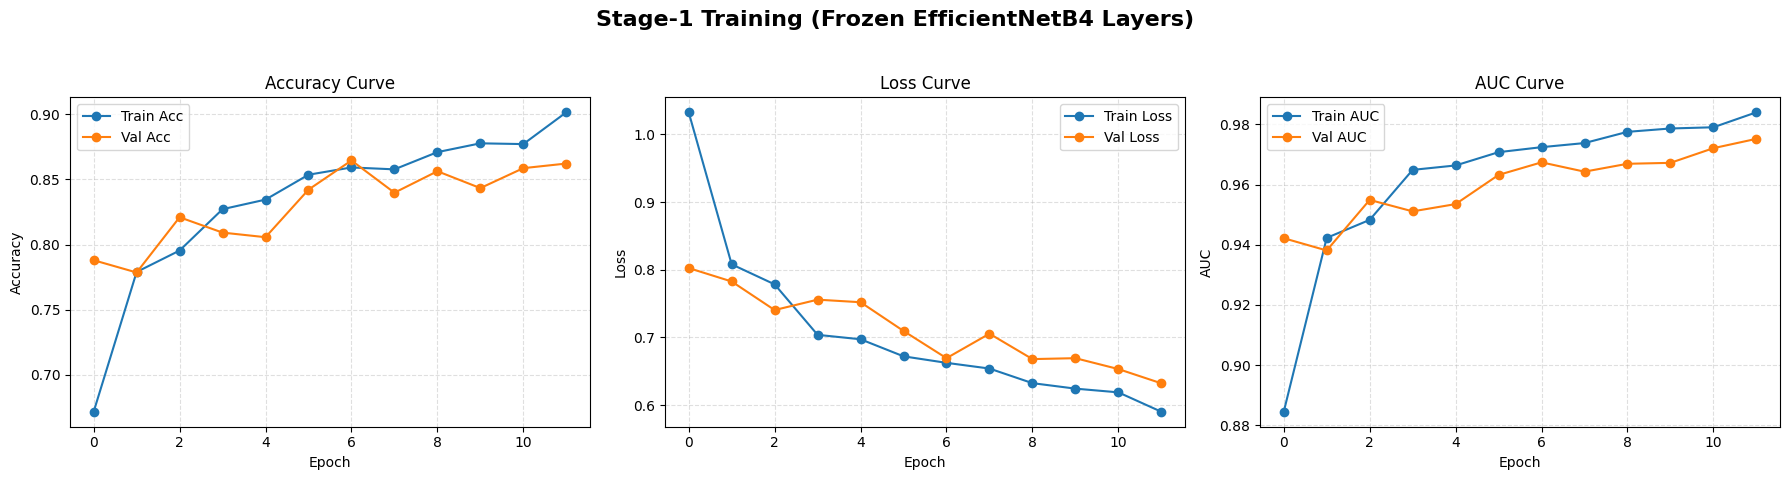

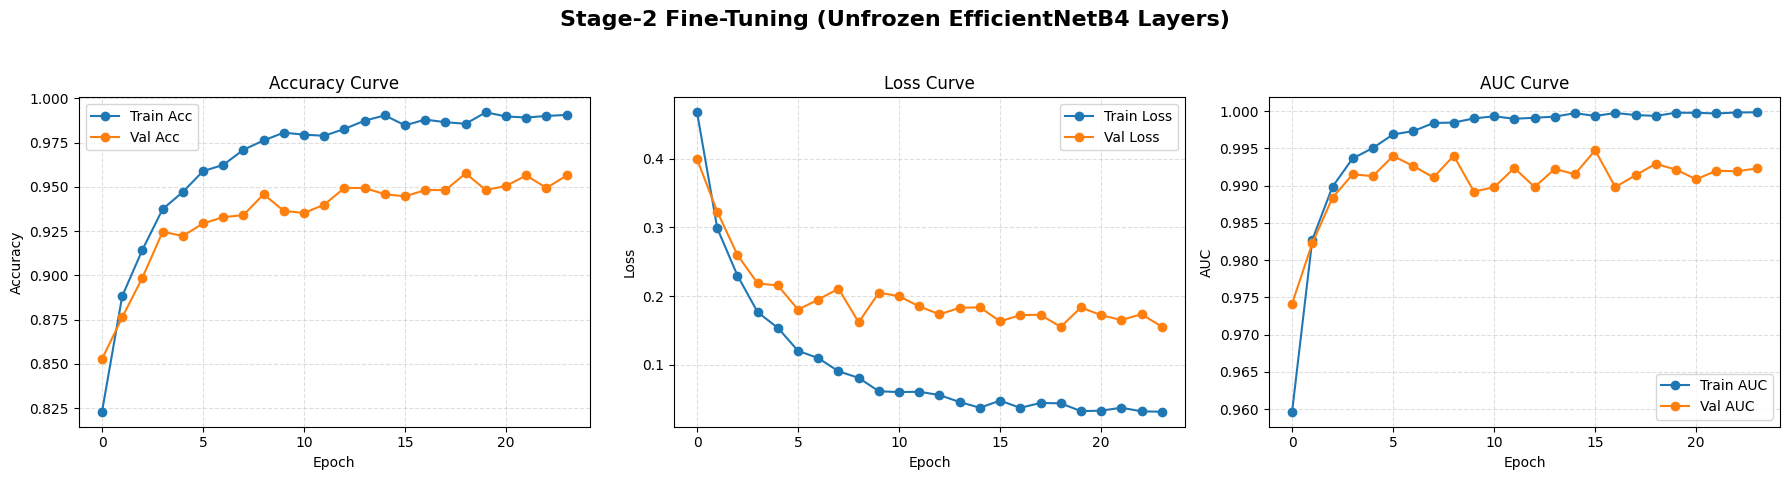

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# =====================================================================
# HISTORY PLOT (Accuracy, Loss, AUC)
# =====================================================================
def plot_history(history, title):
    plt.figure(figsize=(18,5))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # ---------------------- Accuracy ----------------------
    plt.subplot(1,3,1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    # ---------------------- Loss --------------------------
    plt.subplot(1,3,2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    # ---------------------- AUC ---------------------------
    if "auc" in history.history:
        plt.subplot(1,3,3)
        plt.plot(history.history['auc'], marker='o', label='Train AUC')
        plt.plot(history.history['val_auc'], marker='o', label='Val AUC')
        plt.title("AUC Curve")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()
    else:
        print("AUC metric not found in history keys.")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot Stage 1 and Stage 2 training curves
plot_history(history_stage1, "Stage-1 Training (Frozen EfficientNetB4 Layers)")
plot_history(history_stage2, "Stage-2 Fine-Tuning (Unfrozen EfficientNetB4 Layers)")

Found 1000 images belonging to 4 classes.

Running evaluation on TEST set...

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step


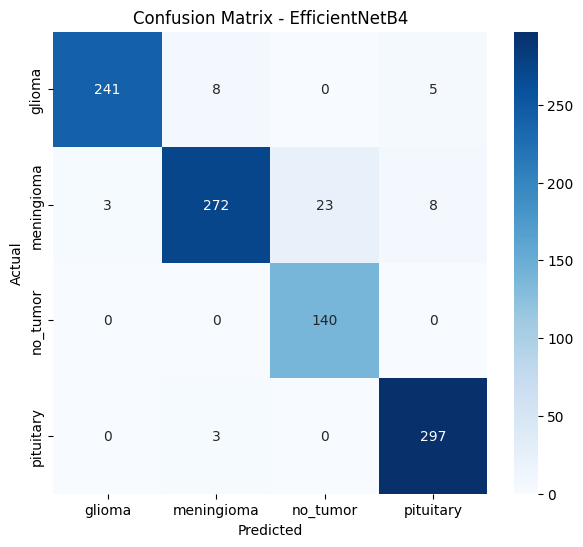


Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       254
  meningioma       0.96      0.89      0.92       306
    no_tumor       0.86      1.00      0.92       140
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.95      1000
   macro avg       0.94      0.96      0.95      1000
weighted avg       0.95      0.95      0.95      1000


Per-class AUC scores:
glioma: 0.9983
meningioma: 0.9940
no_tumor: 0.9999
pituitary: 0.9995


In [3]:
# ===========================================================
# RECREATE TEST GENERATOR (required!)
# ===========================================================
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# ===========================================================
# MODEL EVALUATION
# ===========================================================
print("\nRunning evaluation on TEST set...\n")

test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)

y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# ===========================================================
# CONFUSION MATRIX
# ===========================================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB4")
plt.show()

# ===========================================================
# CLASSIFICATION REPORT
# ===========================================================
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# PER-CLASS AUC (One-vs-Rest)
# ===========================================================
try:
    y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    aucs = {}

    for i, cname in enumerate(class_names):
        aucs[cname] = roc_auc_score(y_true_bin[:, i], y_prob[:, i])

    print("\nPer-class AUC scores:")
    for cname, auc_val in aucs.items():
        print(f"{cname}: {auc_val:.4f}")

except Exception as e:
    print("Could not compute per-class AUC:", e)
